<img src="https://fsdl.me/logo-720-dark-horizontal">

# Lab 06: Data Annotation

### What You Will Learn

- How the `IAM` handwriting dataset is structured on disk and how it is processed into an ML-friendly format
- How to setup a [Label Studio](https://labelstud.io/) data annotation server
- Just how messy data really is

# Setup

If you're running this notebook on Google Colab,
the cell below will run full environment setup.

It should take about three minutes to run.

In [1]:
lab_idx = 6


if "bootstrap" not in locals() or bootstrap.run:
    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

    # get both Colab and local notebooks into the same state
    !wget --quiet https://fsdl.me/gist-bootstrap -O bootstrap.py
    import bootstrap

    # change into the lab directory
    bootstrap.change_to_lab_dir(lab_idx=lab_idx)

    # needed for inline plots in some contexts
    %matplotlib inline

    bootstrap.run = False  # change to True re-run setup
    
!pwd
%ls

env: PYTHONPATH=.:/env/python
.:/env/python
/content/fsdl-text-recognizer-2022-labs/lab06
notebooks/  tasks/  text_recognizer/  training/


### Follow along with a video walkthrough on YouTube:

In [2]:
from IPython.display import IFrame


IFrame(src="https://fsdl.me/2022-lab-06-video-embed", width="100%", height=720)

# `IAMParagraphs`: From annotated data to a PyTorch `Dataset`

We've used the `text_recognizer.data` submodule
and its `LightningDataModule`s -- `IAMLines` and `IAMParagraphs`
for lines and paragraphs of handwritten text
from the
[IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database).

These classes convert data from a database-friendly format
designed for storage and transfer into the
format our DNNs expect:
PyTorch `Tensor`s.

In this section,
we'll walk through that process in detail.

In the following section,
we'll see how data
goes from signals measured in the world
to the format we consume here.

## Dataset structure on disk

We begin by downloading the raw data to disk.

In [3]:
from text_recognizer.data.iam import IAM

iam = IAM()
iam.prepare_data()

586MB [00:12, 49.0MB/s]                           


Computing SHA-256...
Extracting IAM data


The `IAM` dataset is downloaded as zip file
and then unzipped:

In [4]:
from text_recognizer.metadata.iam import DL_DATA_DIRNAME


iam_dir = DL_DATA_DIRNAME
!ls {iam_dir}

iamdb  iamdb.zip


The unzipped dataset is not simple a flat directory of files.

Instead, there are a number of subfolders,
each of which contains a particular type of data or metadata.

In [5]:
iamdb = iam_dir / "iamdb"

!du -h {iamdb}

583M	/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/forms
7.5M	/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/ascii
120K	/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/task
39M	/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/xml
629M	/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb


For example, the `task` folder contains metadata about canonical dataset splits:

In [6]:
!find {iamdb / "task"} | grep "\\.txt$"

/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/task/validationset1.txt
/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/task/testset.txt
/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/task/validationset2.txt
/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/task/LargeWriterIndependentTextLineRecognitionTask.txt
/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/task/trainset.txt


We find the images of handwritten text in the `forms` folder.

An individual "datapoint" in `IAM` is a "form",
because the humans whose hands wrote the text were prompted to write on "forms",
as below:

/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/forms/a01-000u.jpg


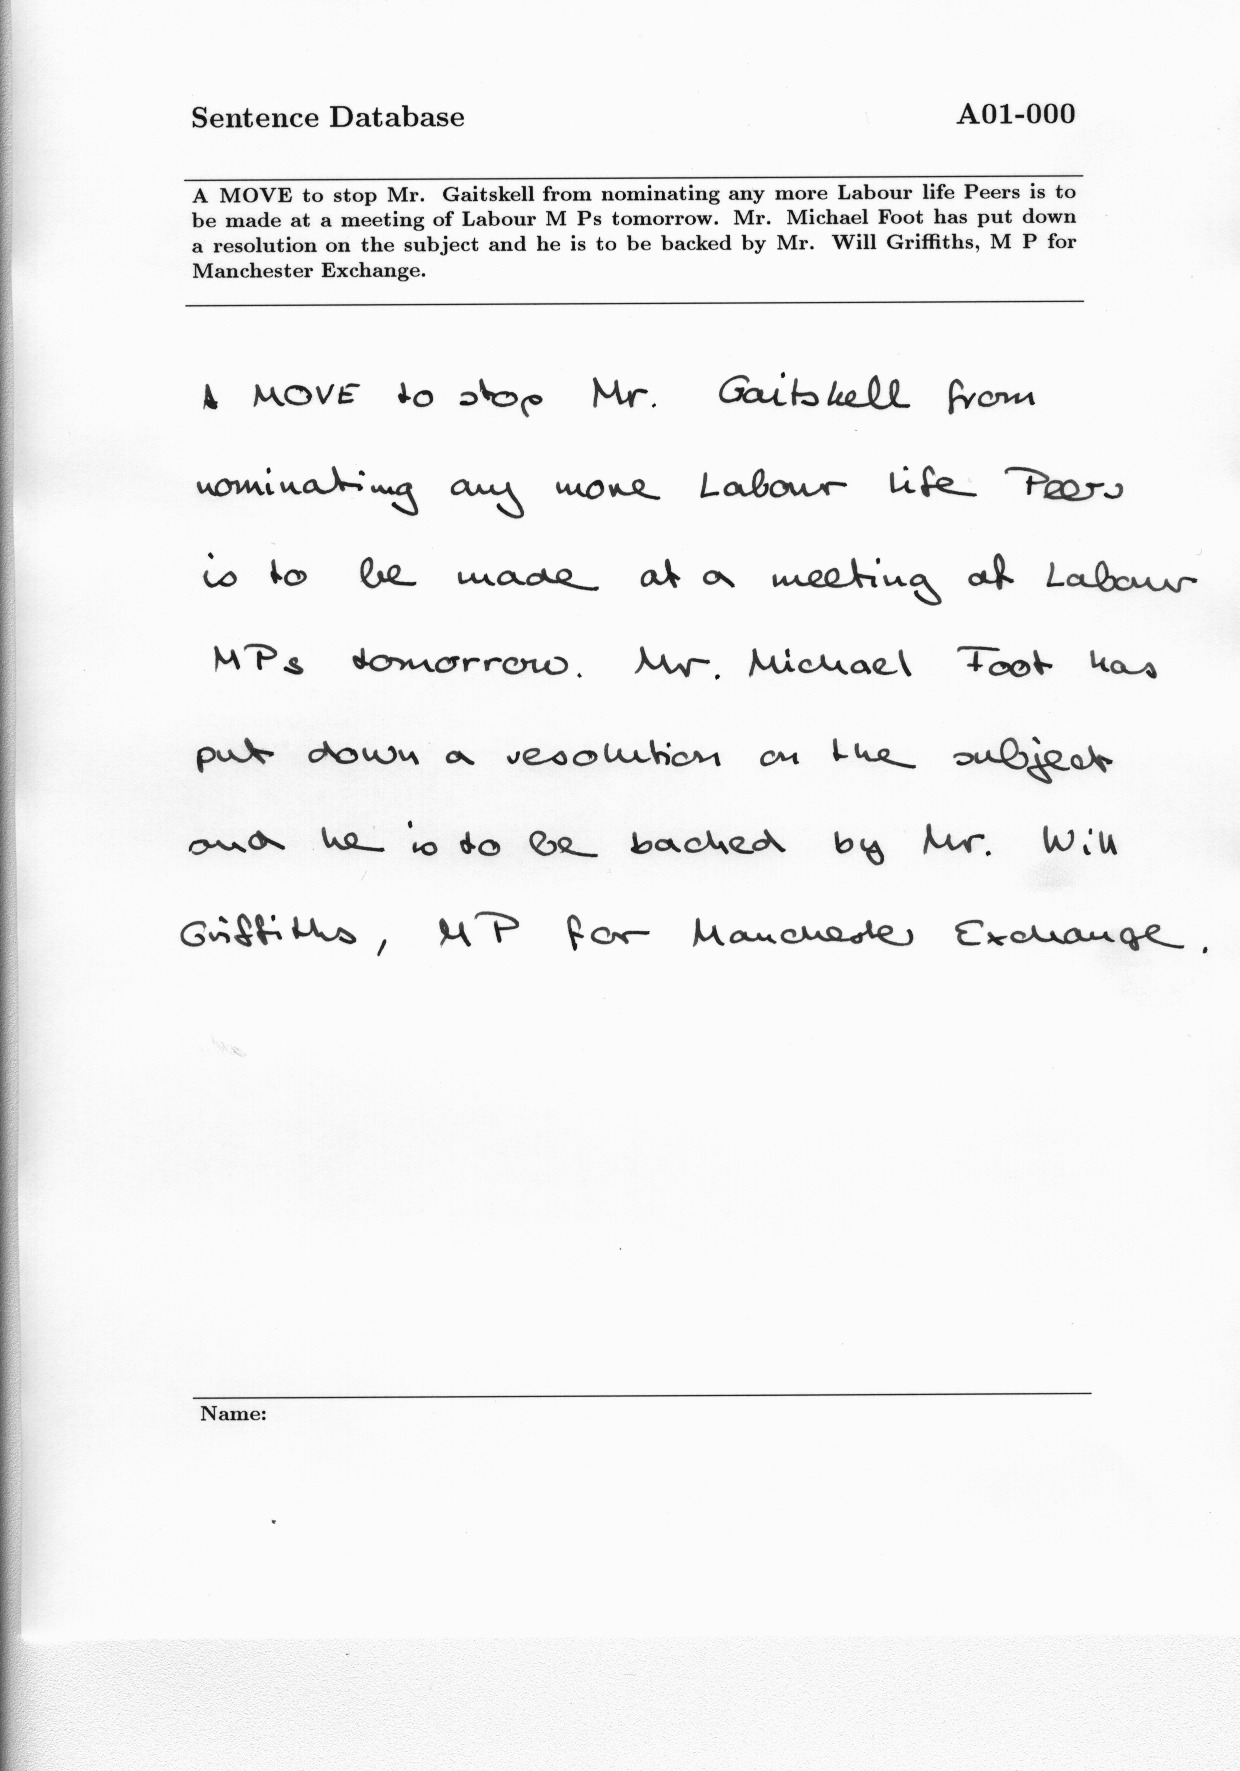

In [7]:
from IPython.display import Image


form_fn, = !find {iamdb}/forms | grep ".jpg$" | sort | head -n 1

print(form_fn)
Image(filename=form_fn, width="360")

Meanwhile, the `xml` files contain the data annotations,
written out as structured text:

In [8]:
xml_fn, = !find {iamdb}/xml | grep "\.xml$" | sort | head -n 1

!cat {xml_fn} | grep -A 100 "handwritten-part" | grep "<word"

      <word id="a01-000u-00-00" sentence-start="yes" tag="AT" text="A">
      <word id="a01-000u-00-01" tag="NN" text="MOVE">
      <word id="a01-000u-00-02" tag="TO" text="to">
      <word id="a01-000u-00-03" tag="VB" text="stop">
      <word id="a01-000u-00-04" tag="NPT" text="Mr.">
      <word id="a01-000u-00-05" tag="NP" text="Gaitskell">
      <word id="a01-000u-00-06" tag="IN" text="from">
      <word id="a01-000u-01-00" tag="VBG" text="nominating">
      <word id="a01-000u-01-01" tag="DTI" text="any">
      <word id="a01-000u-01-02" tag="AP" text="more">
      <word id="a01-000u-01-03" tag="NN" text="Labour">
      <word id="a01-000u-01-04" tag="NN" text="life">
      <word id="a01-000u-01-05" tag="NNS" text="Peers">
      <word id="a01-000u-02-00" tag="BEZ" text="is">
      <word id="a01-000u-02-01" tag="TO" text="to">
      <word id="a01-000u-02-02" tag="BE" text="be">
      <word id="a01-000u-02-03" tag="VBN" text="made">
      <word id="a01-000u-02-04" tag="IN" text="at">
  

Make sure to correlate the `text` field of the XML to the image above.

## Extracting paragraphs from raw data

The raw jpg images and XML labels are not sufficient to train a text recognition model.

That's because the images do not resemble the images we expect users to submit,
for example beause the handwritten text is always paired
with printed text with (nearly) identical content.

Luckily, the XML files contain the position metadata required
to convert images of entire forms into more useful images,
e.g. of lines or paragraphs of handwritten text.

In [9]:
xml_fn, = !find {iamdb}/xml | grep "\.xml$" | sort | head -n 1

!cat {xml_fn} | grep -A 25 "handwritten-part" | grep -A 5 "<word"

      <word id="a01-000u-00-00" sentence-start="yes" tag="AT" text="A">
        <cmp x="408" y="768" width="27" height="51" />
      </word>
      <word id="a01-000u-00-01" tag="NN" text="MOVE">
        <cmp x="507" y="768" width="63" height="46" />
        <cmp x="568" y="770" width="56" height="41" />
        <cmp x="631" y="768" width="38" height="41" />
        <cmp x="676" y="772" width="31" height="36" />
        <cmp x="691" y="766" width="29" height="12" />
--
      <word id="a01-000u-00-02" tag="TO" text="to">
        <cmp x="796" y="764" width="26" height="43" />
        <cmp x="826" y="780" width="40" height="34" />
      </word>
      <word id="a01-000u-00-03" tag="VB" text="stop">
        <cmp x="919" y="783" width="36" height="28" />
        <cmp x="958" y="757" width="77" height="57" />
        <cmp x="1041" y="789" width="44" height="46" />
      </word>
      <word id="a01-000u-00-04" tag="NPT" text="Mr.">
        <cmp x="1185" y="754" width="111" height="61" />
      

So from images of entire forms, as below,
and XML position and label metadata,
we need to extract cropped images
of paragraphs and string labels.

/content/fsdl-text-recognizer-2022-labs/data/downloaded/iam/iamdb/forms/g01-031.jpg


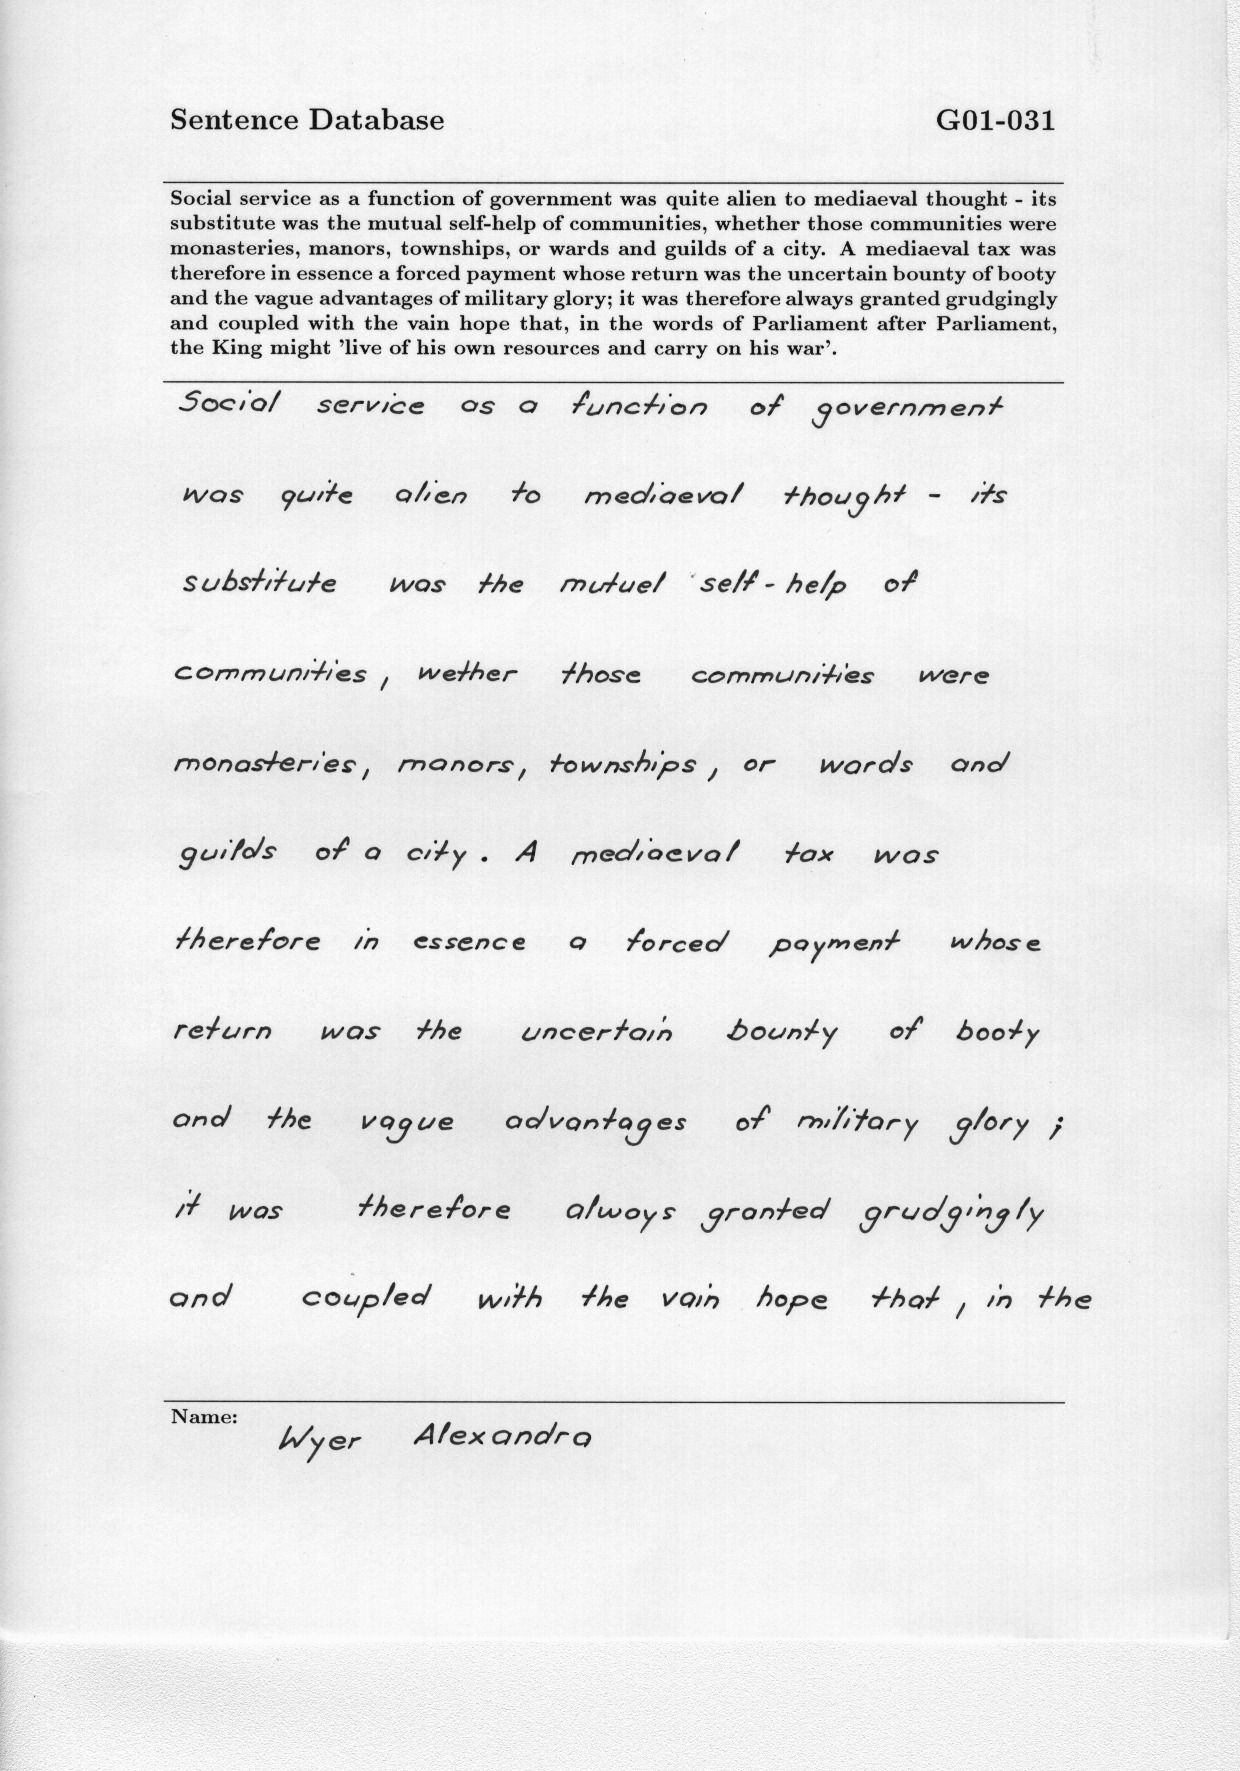

In [10]:
import text_recognizer.util as util

form_id = "g01-031"
fn = iam.form_filenames_by_id[form_id]

print(fn)
Image(filename=fn, width=360)

This is handled by a utility function, `get_paragraph_crops_and_labels`:

Social service as a function of government
was quite alien to mediaeval thought - its
substitute was the mutual self-help of
communities, whether those communities were
monasteries, manors, townships, or wards and
guilds of a city. A mediaeval tax was
therefore in essence a forced payment whose
return was the uncertain bounty of booty
and the vague advantages of military glory;
it was therefore always granted grudgingly
and coupled with the vain hope that, in the


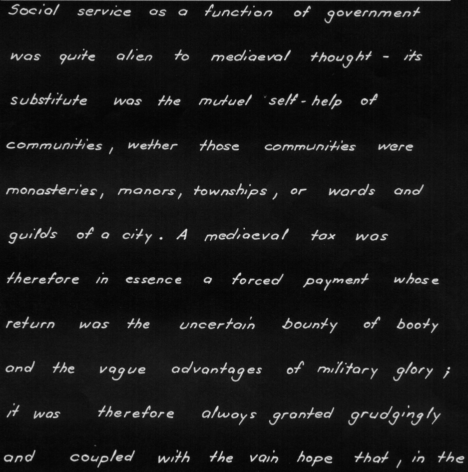

In [11]:
from text_recognizer.data.iam_paragraphs import get_paragraph_crops_and_labels

p_crops, p_labels = get_paragraph_crops_and_labels(iam, split="val")

print(p_labels[form_id])
p_crops[form_id]

The labels are directly available from the XML.

The spatial extents of lines are also directly available from the XML,
as the coordinates of the top-right and bottom-left corners of boxes:

In [12]:
from text_recognizer.data.iam import _get_line_regions_from_xml_file

_get_line_regions_from_xml_file??

And we "join" the spatial extents of the lines together to cover paragraphs.

There are two other pre-processing steps here:

- We resize them so they take up less memory.
- We invert them because many NNs work better
with positive features.

## Structuring into a PyTorch dataset

Lastly, we convert to something we can use with PyTorch and `torchvision`: a PyTorch `Dataset`.

A basic `Dataset` just allows us to index into multiple sources of data
(e.g. the inputs and the targets) at the same time,
via their `__getitem__` method.

This may seem simple -- how hard could it be to keep some indices aligned? --
but consider that PyTorch `Dataset`s implement e.g.
subsetting and shuffling.

Let's look at the `BaseDataset` class we use in the FSDL codebase:

In [13]:
from text_recognizer.data.util import BaseDataset


BaseDataset.__getitem__??

Notice that while indexing into data, the `Dataset` can also perform computations.

When using `DataLoader`s with multi-processing,
i.e. setting the `num_workers` arugment to `1` or more,
these computations are done in a separate process.

So our input images,
which we might want to edit via data augmentation,
are just kept as a list of `PIL` images,
to be turned into `Tensor`s by the `self.transforms` method.

In [14]:
list_crops = list(p_crops.values())

We don't intend to apply any transformations to our targets,
so we just convert them to `Tensor`s now:

In [15]:
from text_recognizer.data.util import convert_strings_to_labels
from text_recognizer.data import IAMParagraphs

iam_paragraphs = IAMParagraphs()

tensor_labels = convert_strings_to_labels(
    strings=p_labels.values(),
    mapping=iam_paragraphs.inverse_mapping,
    length=iam_paragraphs.output_dims[0])

Once we combine these together with a `BaseDataset`,
we're ready to feed data into our neural networks.

In [16]:
from torchvision.transforms import ToTensor

dataset = BaseDataset(list_crops, tensor_labels, transform=ToTensor())

im, label = dataset[0]

im, label

(tensor([[[0.0157, 0.0157, 0.0157,  ..., 0.0275, 0.0275, 0.0196],
          [0.0157, 0.0157, 0.0157,  ..., 0.0196, 0.0196, 0.0235],
          [0.0157, 0.0157, 0.0157,  ..., 0.0235, 0.0196, 0.0235],
          ...,
          [0.0157, 0.0157, 0.0157,  ..., 0.0235, 0.0235, 0.0196],
          [0.0157, 0.0157, 0.0157,  ..., 0.0196, 0.0235, 0.0196],
          [0.0157, 0.0157, 0.0157,  ..., 0.0196, 0.0196, 0.0196]]]),
 tensor([ 1, 14, 51, 45, 66, 15, 40, 57, 59, 54, 53, 76, 66, 62, 47, 54, 66, 48,
         53, 66,  5, 13,  5,  5, 66, 62, 40, 58, 66, 55, 57, 44, 58, 44, 53, 59,
         44, 43, 83, 62, 48, 59, 47, 66, 40, 66, 41, 54, 54, 50, 66, 54, 53, 66,
         59, 47, 44, 66, 51, 48, 45, 44, 66, 54, 45, 66, 26, 40, 57, 63, 76, 83,
         40, 53, 43, 66, 40, 66, 46, 54, 51, 43, 66, 55, 60, 57, 58, 44, 66, 48,
         53, 66, 57, 44, 42, 54, 46, 53, 48, 59, 48, 54, 53, 66, 54, 45, 66, 47,
         48, 58, 83, 62, 54, 57, 50, 66, 45, 54, 57, 66, 59, 47, 44, 66, 52, 54,
         61, 44, 52

## Synthesizing handwritten paragraphs from handwritten lines

The finer-grained the annotations we have for our images,
the more useful our data can be.

For example,
the IAM dataset on its own is quite small.
The total number of forms, and hence paragraphs, is only ~1500.

However, we know that each paragraph is made by stitching together sequential lines
from a single form.

We can create a functionally infinite source of additional synthetic paragraphs
by stitching together lines from different forms and without regard to order.

Since the `__getitem__` method of a `Dataset` runs in a separate process
and is allowed to transform data,
we can, with care,
just generate the data on the fly inside that method.

In [17]:
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphsDataset


IAMSyntheticParagraphsDataset.__getitem__??

INFO:pytorch_lightning.utilities.rank_zero:IAMSyntheticParagraphs.prepare_data: preparing IAM lines for synthetic IAM paragraph creation...
INFO:pytorch_lightning.utilities.rank_zero:Cropping IAM line regions and loading labels for train data split...
INFO:pytorch_lightning.utilities.rank_zero:IAMSyntheticParagraphs.setup(None): Loading train IAM paragraph regions and lines...


Setting seed to 0 for worker None


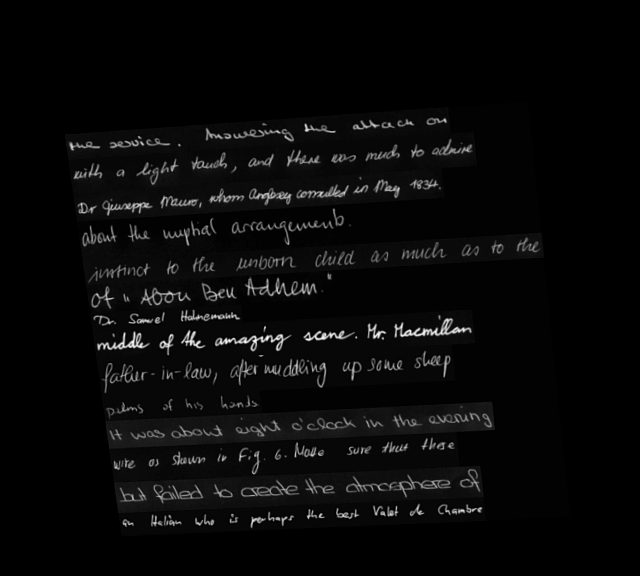

In [18]:
import wandb  # for the convenient method to visualize Tensors as images

from text_recognizer.data import IAMSyntheticParagraphs

iam_synthetic_paragraphs = IAMSyntheticParagraphs()

iam_synthetic_paragraphs.prepare_data()
iam_synthetic_paragraphs.setup()


wandb.Image(iam_synthetic_paragraphs.data_train[0][0]).image

This additional synthetic data doesn't quite look like
the real data we expect to see in production,
nor is it entirely different from the data we already collected,
but it's sufficient to help our model learn better.

# FSDL Handwriting Dataset: From images to an annotated dataset

Above, we relied on an existing dataset,
already cleanly organized into images
and associated annotation files.

But data does not come to us like this.

Model inputs are generally collected or measured from the world somehow,
and annotations are often collected from humans.

Let's now walk through how that's done.

We'll use a dataset of text prompts
and handwritten responses collected during the 2019 edition of FSDL.

## Handling Data with AWS S3

We begin a few steps after the beginning:
data has been collected from humans who were tasked with
writing out text prompts by hand on paper forms,
and those forms were scanned and digitized.

The digitized forms were placed in storage on Amazon Web Services'
Simple Storage Service, aka S3,
which is a form of
[object storage](https://en.wikipedia.org/wiki/Object_storage).

Objects are placed into _buckets_.
Buckets are, under the hood, totally flat,
unlike the tree-structured storage we have in filesystems.
Buckets cannot contain buckets, only objects.

However, we can organize buckets into folders,
which can contain folders,
getting back something that looks a bit more like a traditional filesystem,
but which is now internet-native.

For example, the forms in our dataset all have URLs:

In [19]:
s3_bucket_name = "fsdl-public-assets"  # objects are placed into buckets
s3_directory_path = "fsdl_handwriting_20190302"  # buckets can contain "folders" for organization
# we combine this information into a base URL format for the data:
s3_url = f"https://{s3_bucket_name}.s3.us-west-2.amazonaws.com/{s3_directory_path}"
s3_url

'https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302'

Because this S3 bucket is publicly accessible,
the contents can be displayed just using the URL:

In [20]:
from IPython.display import Image

idx = 117
img_url = f"{s3_url}/page-{str(idx).zfill(3)}.jpg"
print(img_url)
Image(url=img_url, width=360)

https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302/page-117.jpg


That's nice for basic tasks,
like accessing an individual file.
For programmatic access to large numbers of files,
we'll want an SDK or a CLI.

We use
[`boto3`](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html),
the Python SDK for Amazon Web Services.

It is named after the Portuguese term for
[river dolphins native to the Amazon river](https://en.wikipedia.org/wiki/Boto).

In [21]:
import boto3  # boto3: high-level API
from botocore import UNSIGNED  # botocore: lower-level API and components
from botocore.config import Config


# spin up a client for communicating with s3 without authenticating ("UNSIGNED" activity)
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

Let's start by just downloading a single file
to the local filesystem.

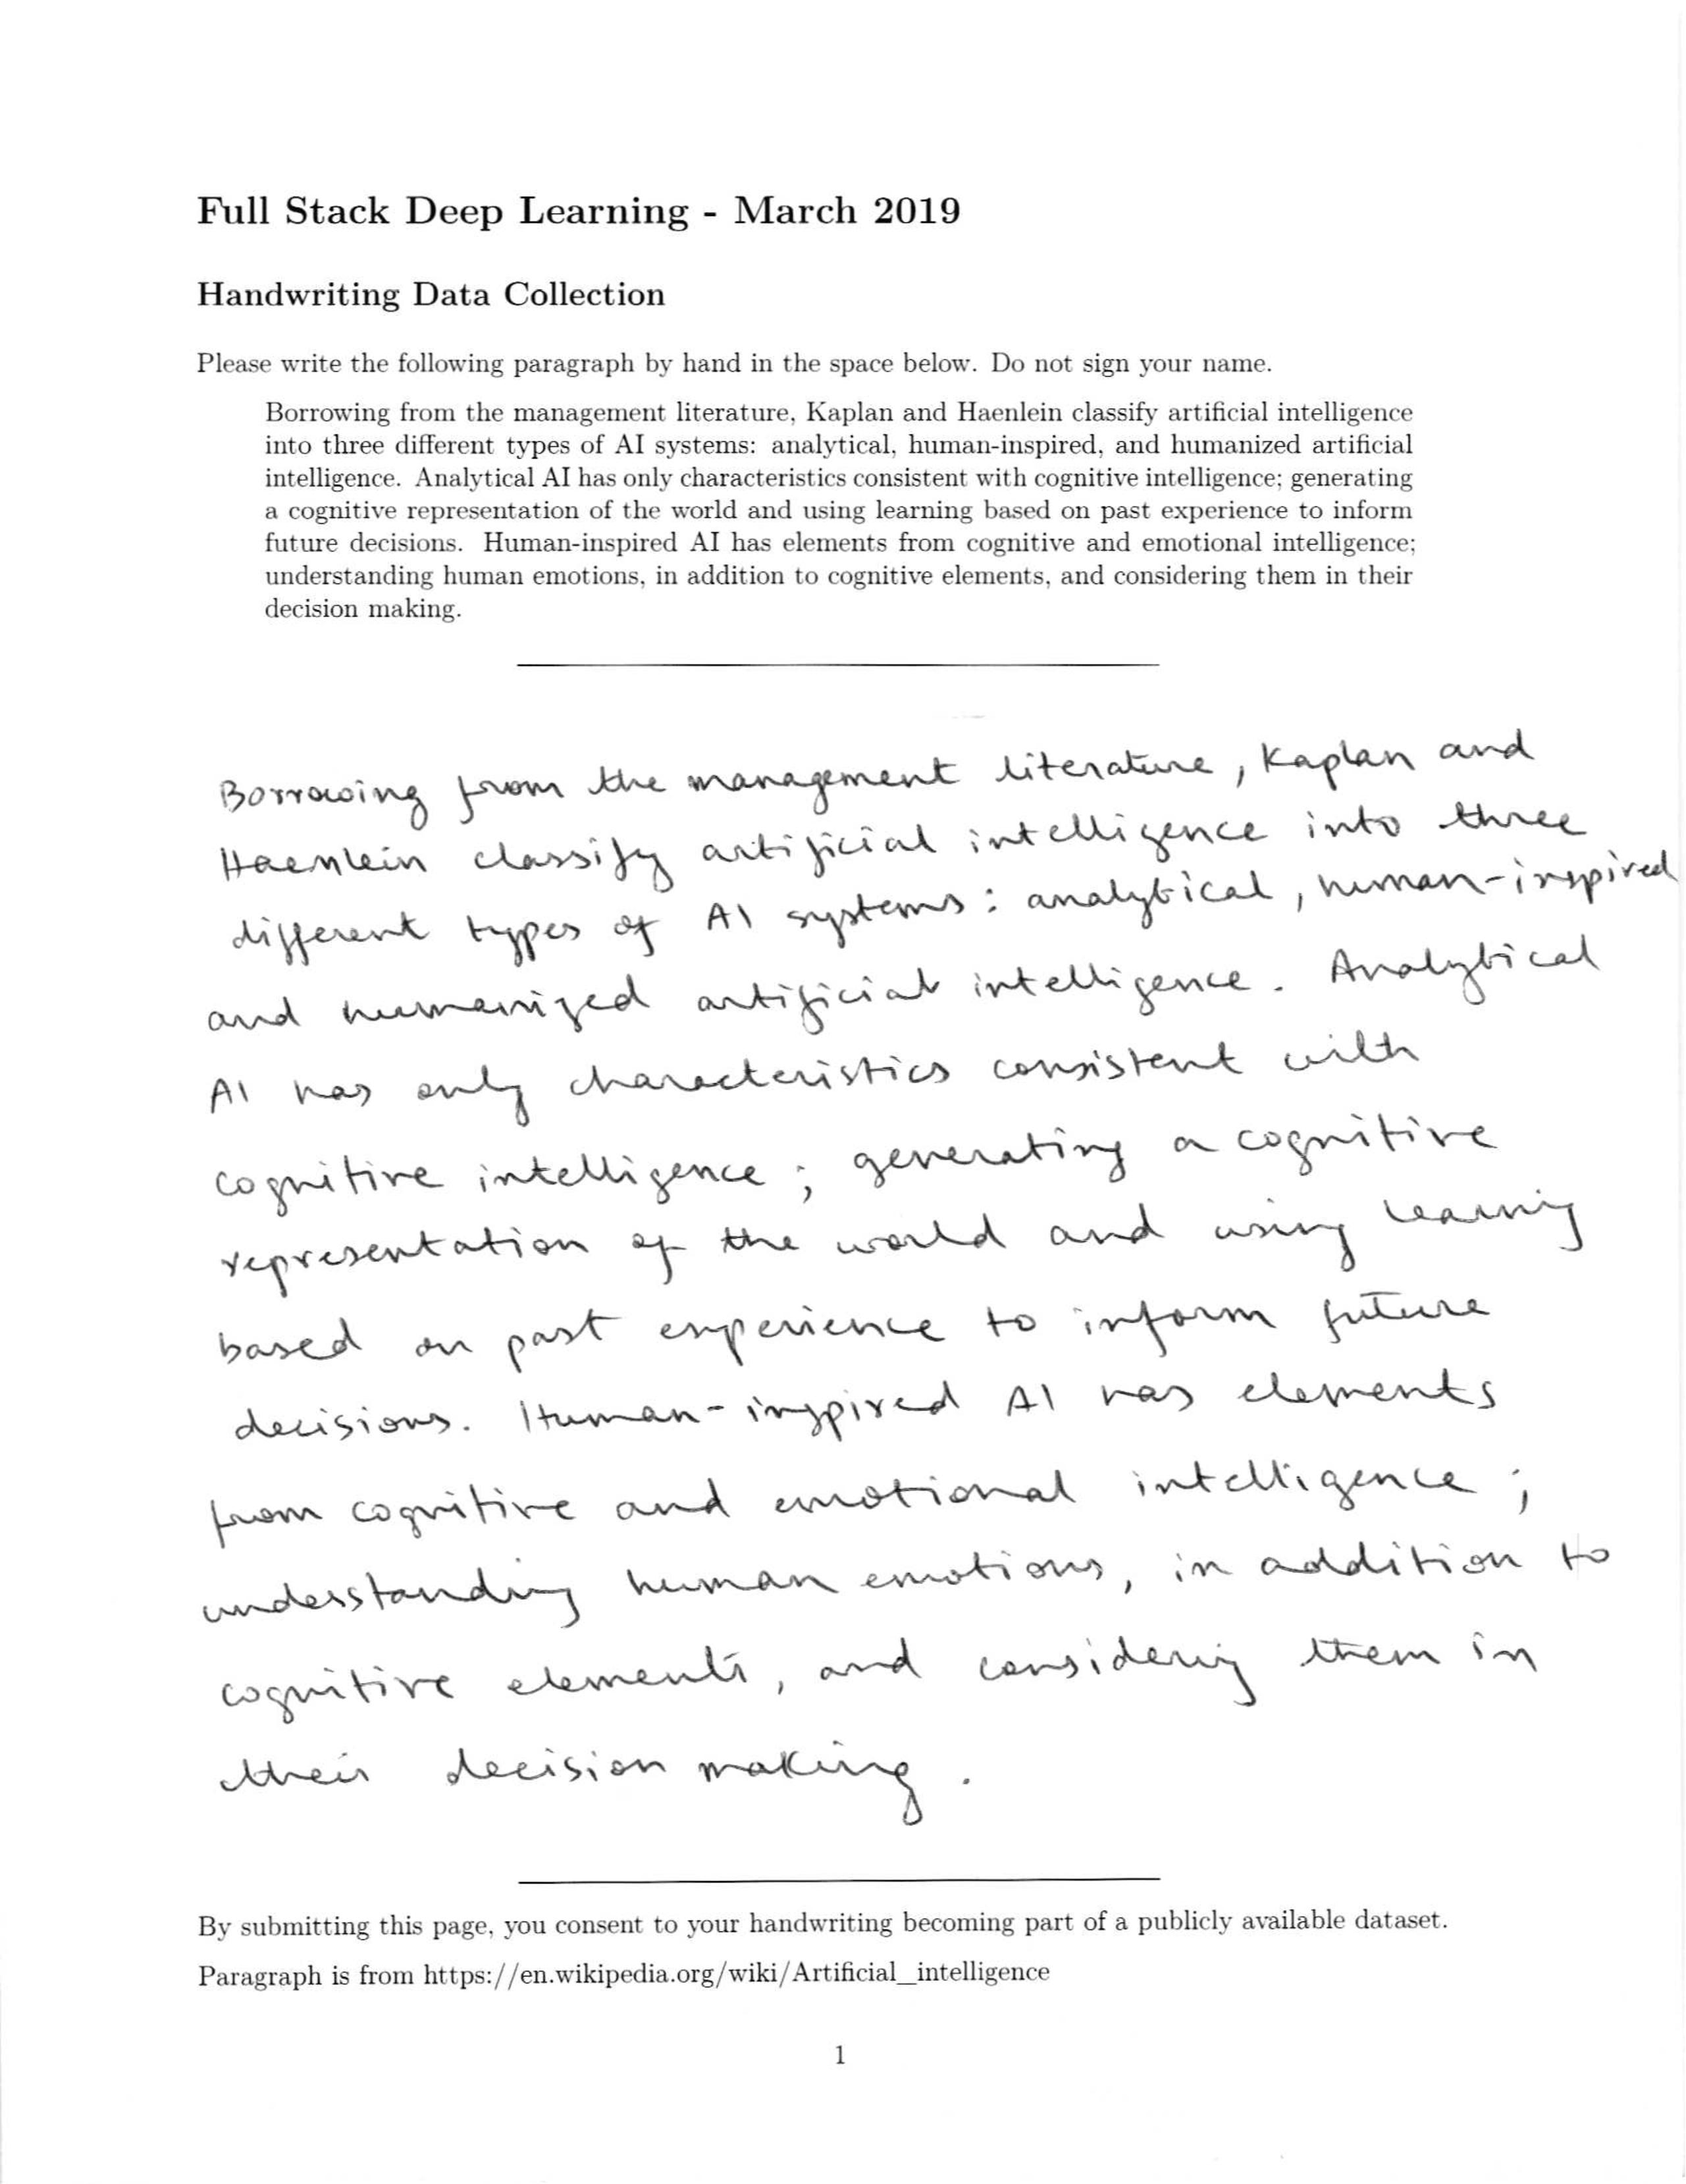

In [22]:
from IPython.display import Image

from text_recognizer.metadata.shared import DATA_DIRNAME


FSDL_RAW_DATA_DIRNAME = DATA_DIRNAME / "raw" / "fsdl_handwriting"
FSDL_DL_DATA_DIRNAME = DATA_DIRNAME / "downloaded" / "fsdl_handwriting"/ "pages"

!mkdir -p {FSDL_DL_DATA_DIRNAME}

s3.download_file(
    "fsdl-public-assets", "fsdl_handwriting_20190302/page-001.jpg", f"{FSDL_DL_DATA_DIRNAME}/page-001.jpg")

Image(filename=f"{FSDL_DL_DATA_DIRNAME}/page-001.jpg", width=720)

To pull down more data,
e.g. all 117 forms from this dataset,
we'll need to write a helper method.

In [23]:
import os


s3_resource = boto3.resource('s3', config=Config(signature_version=UNSIGNED))


def download_s3_folder(bucket_name, s3_folder, local_dir=None):
    """Download the contents of a folder on S3, recursively.

    Parameters
    ----------
    bucket_name: the name of the s3 bucket
    s3_folder: the folder path in the s3 bucket
    local_dir: a relative or absolute directory path in the local file system
    """
    # from https://stackoverflow.com/questions/49772151/download-a-folder-from-s3-using-boto3
    bucket = s3_resource.Bucket(bucket_name)
    for obj in bucket.objects.filter(Prefix=s3_folder):
        target = obj.key if local_dir is None \
            else os.path.join(local_dir, os.path.relpath(obj.key, s3_folder))
        if not os.path.exists(os.path.dirname(target)):
            os.makedirs(os.path.dirname(target))
        if obj.key[-1] == '/':
            continue
        bucket.download_file(obj.key, target)
        
        
download_s3_folder("fsdl-public-assets", "fsdl_handwriting_20190302", FSDL_DL_DATA_DIRNAME)

We can confirm this worked by checking the directory contents:

In [24]:
!find {FSDL_DL_DATA_DIRNAME} | head -n 20

/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages
/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages/page-059.jpg
/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages/page-045.jpg
/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages/page-010.jpg
/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages/page-006.jpg
/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages/page-016.jpg
/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages/page-036.jpg
/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages/page-014.jpg
/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages/page-054.jpg
/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages/page-040.jpg
/content/fsdl-text-recognizer-2022-labs/data/downloaded/fsdl_handwriting/pages/page-051.jpg
/

For more on using `boto3` with S3,
including authentication, uploading, and configuration,
we refer the interested reader to the
[Real Python tutorial](https://realpython.com/python-boto3-aws-s3/).

## Annotation with Label Studio

As noted above,
these raw forms are not useful for learning the text recognition task.

There are no targets for our model to learn to produce and
there are no other annotations that can help us transform the data,
e.g. pulling out paragraphs or lines.

In this as in most cases, these annotations must be added manually.

Many programmers and data scientists consider this sort of manual labor
to be uninteresting and so ignore it or outsource it entirely.

This is a mistake!



### Configuring and connecting to the web server

Much like many of the other tools we have used so far
(TensorBoard, W&B, Jupyter)
Label Studio operates on a client-server model,
with clients mostly using a browser.

Here, the annotation server tracks things like
- user authentication credentials
- annotation task definitions
- past annotation information
- which data still requires annotation

The client's browser renders the annotation interface,
where users can click and type to annotate the data visually and interactively,
with the results saved as structured text.

So we'll be running a labelling webservice.

That means that before we can spin Label Studio up,
we'll need to solve a few problems.

First, we need to configure the administrative user
with a username and a password:

In [25]:
username = "fsdl@localhost"
password = "pancakes"

%env LABEL_STUDIO_USERNAME={username}
%env LABEL_STUDIO_PASSWORD={password}

env: LABEL_STUDIO_USERNAME=fsdl@localhost
env: LABEL_STUDIO_PASSWORD=pancakes


Notice that we are configuring our web service
with environment variables
(`%env` in Jupyter).

This is considered
[a good design pattern for applications](https://12factor.net/config).

We'll be running the webservice from this notebook,
but we want to be able to connect to it from the public internet.

You can set this up yourself if you have control of the network
and device you are using and know a bit about
firewalls and port-forwarding.

But this isn't always the case,
and even when it is,
often requires platform-specific
configuration.

The easiest way to set up a basic webservice
without worrying about these issues is a tool called
[`ngrok`](https://ngrok.io/),
which we'll also use when it comes time to serve our application.

[Sign up for a free `ngrok` account](https://dashboard.ngrok.com/signup)
and then run the cell below
to enter your authentication token
if you haven't done so already.

In [26]:
import os
import getpass

from pyngrok import ngrok

config_file = ngrok.conf.DEFAULT_NGROK_CONFIG_PATH
config_file_exists =  os.path.exists(config_file)
config_file_contents = !cat {config_file}

auth_token_found = config_file_exists \
    and config_file_contents \
    and "authtoken" in config_file_contents[0] \
    and ": exit" not in config_file_contents  # state if interrupted

if not auth_token_found:
    print("Enter your ngrok auth token, which can be copied from https://dashboard.ngrok.com/auth")
    !ngrok authtoken {getpass.getpass()}

Enter your ngrok auth token, which can be copied from https://dashboard.ngrok.com/auth
··········
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


`ngrok` creates a tunnel from the local service
to the ngrok.io servers
and then exposes that service via an ngrok-controlled URL.

The cell below creates a tunnel pointing at the local port
on which Label Studio will be listening for requests.

In [27]:
LABEL_STUDIO_PORT = 8081
%env LABEL_STUDIO_PORT={LABEL_STUDIO_PORT}

https_tunnel = ngrok.connect(LABEL_STUDIO_PORT, bind_tls=True)
print(https_tunnel)

env: LABEL_STUDIO_PORT=8081
NgrokTunnel: "https://3435-35-197-82-118.ngrok.io" -> "http://localhost:8081"


Lastly, we need to install Label Studio,
because Label Studio is not included
in the development environment
for the labs.

That's because it's not compatible with many of our other libraries,
due to a very strict requirement specification.

Rather than expecting to be used as one library among many
in a development environment,
like the rest of our tools,
Label Studio expects to be used more like an application.

That means it's generally run on a server or inside of a container
that isn't doing anything else.

Because of these constraints,
we'll briefly install Label Studio here, from inside the notebook,
and then clean it up from our environment at the end,
by re-running our `make pip-tools` command.

In [28]:
!pip install -qqq label-studio

     |████████████████████████████████| 41.6 MB 1.3 MB/s 
     |████████████████████████████████| 199 kB 91.8 MB/s 
     |████████████████████████████████| 7.2 MB 55.1 MB/s 
     |████████████████████████████████| 495 kB 68.7 MB/s 
     |████████████████████████████████| 3.4 MB 44.7 MB/s 
     |████████████████████████████████| 1.4 MB 80.1 MB/s 
     |████████████████████████████████| 56 kB 6.1 MB/s 
     |████████████████████████████████| 1.6 MB 60.1 MB/s 
     |████████████████████████████████| 100 kB 670 kB/s 
     |████████████████████████████████| 73 kB 1.9 MB/s 
     |████████████████████████████████| 103 kB 68.7 MB/s 
     |████████████████████████████████| 222 kB 84.2 MB/s 
     |████████████████████████████████| 377 kB 98.0 MB/s 
     |████████████████████████████████| 130 kB 71.3 MB/s 
     |████████████████████████████████| 246 kB 66.0 MB/s 
     |████████████████████████████████| 85 kB 5.1 MB/s 
     |████████████████████████████████| 509 kB 63.1 MB/s 
     |███████████████

Now, we're ready to kick off our webservice by running it (`script bash`)
in the `b`ack`g`round.

In [29]:
%%script bash --bg --proc label_studio_proc

label-studio start --port=$LABEL_STUDIO_PORT

It should take at most 30 seconds to start.

Once it has,
you can put the URL below into your browser
to access the Label Studio server
and log in with the credentials below.

In [30]:
print(https_tunnel.public_url)
print("u:", username)
print("p:", password)

https://3435-35-197-82-118.ngrok.io
u: fsdl@localhost
p: pancakes


See the
[video walkthrough for this lab](https://fsdl.me/2022-lab-06-video)
for a tour of the interface
and a demonstration of how to set up data labelling for the first exercise below.

### Uploading data

Label Studio isn't particularly useful without data to label.

The simplest format that Label Studio accepts is a CSV
where each row is a different datapoint.

The cell below prints the path and first ten lines
of a CSV in this format for the FSDL Handwriting dataset.

In [31]:
print(FSDL_RAW_DATA_DIRNAME / "manifest.csv")
!cat {FSDL_RAW_DATA_DIRNAME}/manifest.csv | head -n 10

/content/fsdl-text-recognizer-2022-labs/data/raw/fsdl_handwriting/manifest.csv
form
https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302/page-001.jpg
https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302/page-002.jpg
https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302/page-003.jpg
https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302/page-004.jpg
https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302/page-005.jpg
https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302/page-006.jpg
https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302/page-007.jpg
https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302/page-008.jpg
https://fsdl-public-assets.s3.us-west-2.amazonaws.com/fsdl_handwriting_20190302/page-009.jpg


In Label Studio,
you can upload this file via the "Import Data" interface.

Note that the interface opens a file dialog box on the machine running the browser,
which may not be the same machine executing the notebook where this CSV file is written.

In that case, you'll need to download the CSV file to your machine using the file tools
built into Jupyter/Colab
before you can upload it to Label Studio.

# Exercises

### 🌟 Label at least five pages of data in Label Studio.

Follow the instructions in the video to set up
the annotation task and then complete it for at least five pages' worth of data.

As you're doing so,
pay close attention to the data.

Where are there unexpected ambiguities or edge cases?
How do you resolve them?

In general, you'll want to consider the downstream model behavior
you intend to exemplify with the data
and the data you expect the model to see in production.

Here are three interesting pages,
which range from very obvious issues to very subtle ones: #24, #35, #97.

### 🌟🌟 Hook up S3 directly to Label Studio.

Label Studio makes it very straightforward to hook data in cloud storage,
like our data, into the labelling server.

However, it requires an AWS account, since
integrating with cloud storage
is typically used with controlled access.

If you don't have one already,
[create an AWS account](https://aws.amazon.com/premiumsupport/knowledge-center/create-and-activate-aws-account/).
We won't be using any paid features.

Then, follow the guide
[here](https://labelstud.io/guide/storage.html#Set-up-connection-in-the-Label-Studio-UI).

Because our data is public,
you will not need to configure access with IAM, use pre-signed URLs or provide a Session Token.

Our region is `us-west-2`.
The bucket name and bucket prefix are above,
in the section on downloading from S3 with `boto3`.

For the filter regex, note that all files end with `.jpg`.

# Teardown

As described above,
the Label Studio application
isn't part of our model development environment,
so we need to uninstall it before moving on to future labs.

The cell below shuts down Label Studio and,
for notebooks running locally,
returns the environment to its default state.

In [ ]:
import os
import sys


in_colab = "google.colab" in sys.modules
done_with_label_studio = True

if done_with_label_studio:
    !pkill -P {label_studio_proc.pid}
    if not in_colab:  # colab environments are ephemeral, no need to clean up
        if "Makefile" in os.listdir():
            !make pip-tools-lint
        else:
            !cd ../ && make pip-tools